# Read GeoTIFF data through a BMI

This notebook describes how to open and read data from GeoTIFF files
using a [Basic Model Interface](https://bmi.readthedocs.io/) (BMI) through the `BmiGeoTiff` class included in the `bmi-geotiff` package.

## Setup

To ensure all dependencies are met, set up a conda environment using the environment file found in the root directory of this repository:
```
conda env create --file=environment.yml
```

Then install the `bmi-geotiff` package:
```
make install
```

Import a set of libraries for later use:

In [1]:
import numpy as np
from rasterio.plot import show

## Open a file

Import the `BmiGeoTiff` class from the `bmi-geotiff` package:

In [2]:
from bmi_geotiff import BmiGeoTiff

Create an instance of this class.

In [3]:
m = BmiGeoTiff()

Calling `help` on the instance displays all the BMI methods that are available.

In [4]:
help(m)

Help on BmiGeoTiff in module bmi_geotiff.bmi object:

class BmiGeoTiff(bmipy.bmi.Bmi)
 |  BmiGeoTiff() -> None
 |  
 |  BMI-mediated access to data and metadata in a GeoTIFF file.
 |  
 |  Method resolution order:
 |      BmiGeoTiff
 |      bmipy.bmi.Bmi
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  finalize(self) -> None
 |      Perform tear-down tasks for the model.
 |      
 |      Perform all tasks that take place after exiting the model's time
 |      loop. This typically includes deallocating memory, closing files and
 |      printing reports.
 |  
 |  get_component_name(self) -> str
 |      Name of the component.
 |      
 |      Returns
 |      -------
 |      str
 |          The name of the component.
 |  
 |  get_current_time(self) -> float
 |      Current time of the model.
 |      
 |      Returns
 |      -------
 |      float
 |          

The first step in using a BMI is calling the `initialize` method.
This method requires a configuration file that provides initial values for the `GeoTiff` library wrapped by the BMI.

A sample configuration file is provided in the current directory.

In [5]:
ls

RGB.byte.tif@      config.yaml        readme_example.py
bmi-geotiff.ipynb  geotiff.ipynb


In [6]:
cat config.yaml

bmi-geotiff:
  filename: RGB.byte.tif


In this case, the configuration file simply lists the path to a GeoTIFF file
(here, the test file RGB.byte.tif from the [rasterio](https://rasterio.readthedocs.io/) project).

Call `initialize` with the sample configuration file:

In [7]:
m.initialize("config.yaml")

The GeoTIFF file listed in the configuration file has now been opened,
and the information is contains can be accessed through BMI methods.

## Access data through the BMI

Now that we've opened the GeoTIFF file, let's access the data and metadata it contains through the BMI.
This will take a few steps.
It may seem cumbersome at first, but there's payoff at the end.

Start by displying the names of the variables exposed through the BMI.

In [8]:
m.get_output_var_names()

('gis__raster_data',
 'gis__coordinate_reference_system',
 'gis__gdal_geotransform')

The (long) names used for these variables are instances of [CSDMS Standard Names](https://csdms.colorado.edu/wiki/CSDMS_Standard_Names).
Standard Names are intended to be unambiguous; the tradeoff is that they tend to be long.
Here, the first variable is for the raster data stored in the file.

Find the data type of the raster.

In [9]:
dtype = m.get_var_type("gis__raster_data")
dtype

'uint8'

Within the BMI, functions that describe the grids that variables are defined on take an index instead of a variable name.

Get the grid index for the raster data variable.

In [10]:
grid = m.get_var_grid("gis__raster_data")
grid

0

Then find the total size of the raster data.

In [11]:
size = m.get_grid_size(grid)
size

1703814

Next, get the raster data values.

Two notes, however:

* As a rule, memory should not be allocated within a BMI. This leads to the un-Pythonic way that we get the data--first creating an empty array, then passing it to a BMI function to receive values.
* BMI arrays are flattened. This obviates array ordering issues between languages, but it does make >1D data harder to work with.

Allocate an array for the raster data.

In [12]:
raster = np.ndarray(size, dtype)
raster

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Get the data.

In [13]:
m.get_value("gis__raster_data", raster)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Note that the array is one-dimensional.

In [14]:
raster.shape

(1703814,)

### Reshape the data

Like all BMI arrays, the raster values returned from the BMI `get_value` function are flattened.
Let's restore their original dimensionality.

First, determine the dimensionality of the raster variable.

In [15]:
rank = m.get_grid_rank(grid)
rank

3

Get the dimensions of the raster data, first creating an array to store their values.

In [16]:
shape = np.empty(rank, dtype=int)
m.get_grid_shape(grid, shape)

array([  3, 718, 791])

Reshape the raster data, creating a new array.

In [17]:
rasterRGB = raster.reshape(shape)

In [18]:
rasterRGB.shape

(3, 718, 791)

### Get map projection information

The data in the GeoTIFF file are georeferenced.
The second and third variables exposed through the BMI,
"gis__coordinate_reference_system" and "gis__gdal_geotransform", respectively,
contain the proj.4 string and the [GDAL geotransform](https://gdal.org/user/raster_data_model.html#affine-geotransform) for the data.

Get the geotransform through the BMI, following a process similar to what was used to obtain the raster data:

* get variable type
* get id of grid on which variable is defined
* get size of grid
* use the above to allocate an array for the transform
* get the transform

In [19]:
dtype = m.get_var_type("gis__gdal_geotransform")
dtype

'float'

In [20]:
grid = m.get_var_grid("gis__gdal_geotransform")
grid

2

In [21]:
size = m.get_grid_size(grid)
size

6

In [22]:
transform = np.ndarray(size, dtype)

In [23]:
m.get_value("gis__gdal_geotransform", transform)
transform

array([ 3.00037927e+02,  0.00000000e+00,  1.01985000e+05,  0.00000000e+00,
       -3.00041783e+02,  2.82691500e+06])

## Visualize

Let's visualize the raster data as an image, with a little help from rasterio.

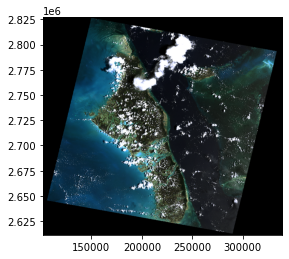

<AxesSubplot:>

In [24]:
show(rasterRGB, transform=list(transform))

## Conclusion

Last, call the BMI `finalize` function.

In [25]:
m.finalize()

This demonstration of the BMI took a lot of code to reproduce a simple result.
So why would anyone want to use the BMI?
The key is that, in this demonstration, only the functions belonging to the BMI were used to access the data.
No knowledge of the calling syntax of the underlying `Topography` class was used.

The lesson is: once you've seen one BMI, you've seen them all!